In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt,find_peaks,find_peaks_cwt

import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import os.path
from os import path

## Read files / Adjust Timestamps

In [2]:
pd.options.display.float_format = '{:,.5f}'.format

In [3]:
malfunctioning= [[2,9,12,14,15,16,17,26,28,36,37],[3,10,11,12,22,25,26,30,32],[1,4,8,11,12,14,15,16,17,25,26,27,30,32,33,34,36]]
perfNumber = 3
allPerformanceData_eda = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
allData_eda = pd.DataFrame()
participantsN = [0, 0, 0]

In [4]:
for performanceNumber in range(perfNumber, perfNumber+1):
    #print ('Performance', performanceNumber)
    for participantNumber in range(1, 50):
        
        participantStr = str(("", "0")[participantNumber < 10])+str(participantNumber)
        filename = "./Performance"+str(performanceNumber)+"/"+str(performanceNumber)+participantStr+"_eda.csv"
        
        if(path.exists(filename)):
            file_eda = pd.read_csv(filename)
            
            if(file_eda.shape[0] > 10000):
                print ('P',performanceNumber, participantNumber, file_eda.shape[0])
                
                freq = 4.545
                fc = 0.01 # Cut-off frequency of the filter
                w = fc / (freq / 2) # Normalize the frequency
                b, a = butter(2, w, 'low')
                file_eda["eda_filtered_good"] = filtfilt(b, a, file_eda["eda"])
                
                file_eda['performanceNumber'] = performanceNumber
                file_eda['participantNumber'] = participantNumber
                file_eda = file_eda.fillna(0)
                allPerformanceData_eda[performanceNumber-1] = allPerformanceData_eda[performanceNumber-1].append(file_eda, ignore_index=True)
        else:
            continue
    participantsN[performanceNumber-1] = allPerformanceData_eda[performanceNumber-1].max()['participantNumber']
    earliestTime = allPerformanceData_eda[performanceNumber-1]['localTime'].min()
    allPerformanceData_eda[performanceNumber-1]['localTimeZeroed'] = allPerformanceData_eda[performanceNumber-1]['localTime'] - earliestTime
    allPerformanceData_eda[performanceNumber-1]['localTimeZeroedSec'] = allPerformanceData_eda[performanceNumber-1]['localTimeZeroed'] / 1000.0
    allPerformanceData_eda[performanceNumber-1]['localTimeZeroedMin'] = allPerformanceData_eda[performanceNumber-1]['localTimeZeroedSec'] / 60.0
    
    
    allData_eda = allData_eda.append(allPerformanceData_eda[performanceNumber-1], ignore_index=True)
    
    allData_eda = allData_eda.drop(allData_eda[allData_eda['localTimeZeroedMin'] < 24].index)
    allData_eda = allData_eda.drop(allData_eda[allData_eda['localTimeZeroedMin'] > 109].index)


P 3 1 28104
P 3 2 27587
P 3 3 28052
P 3 4 28189
P 3 5 28222
P 3 6 28219
P 3 7 28345
P 3 9 28392
P 3 11 28524
P 3 12 28550
P 3 13 28570
P 3 14 28326
P 3 17 28366
P 3 19 28432
P 3 21 28581
P 3 22 28611
P 3 23 28588
P 3 25 28575
P 3 26 28588
P 3 27 28568
P 3 28 28598
P 3 29 28610
P 3 30 28578
P 3 31 28565
P 3 32 28612
P 3 34 28621
P 3 35 28577
P 3 36 28566
P 3 40 28496
P 3 41 28545
P 3 42 28583


## Find EDA extrema

In [ ]:
dfminmax = pd.DataFrame()

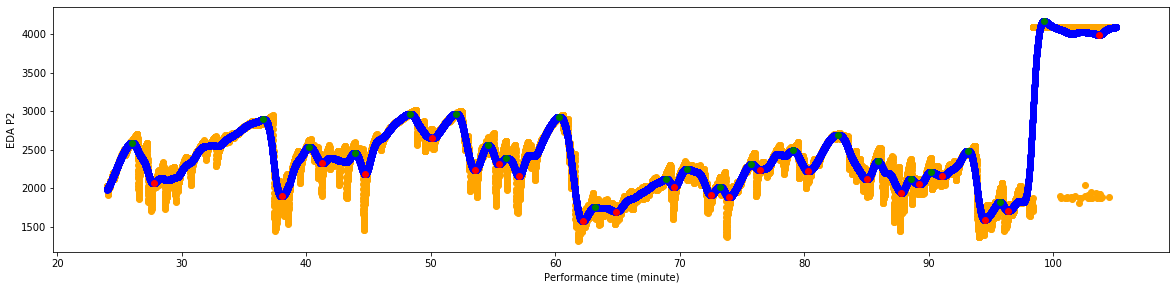

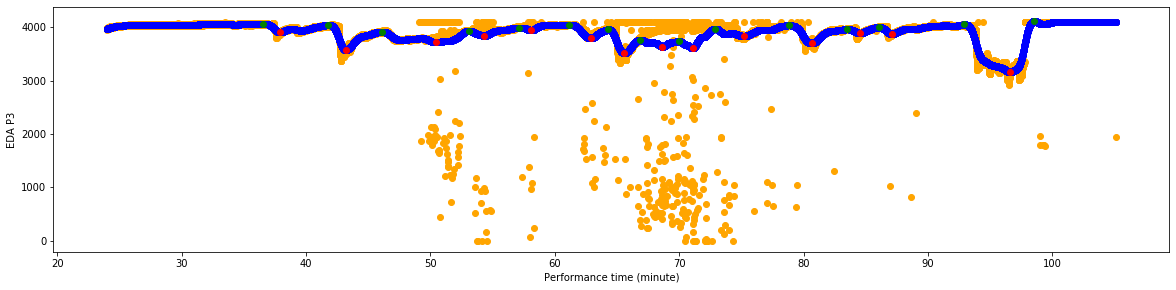

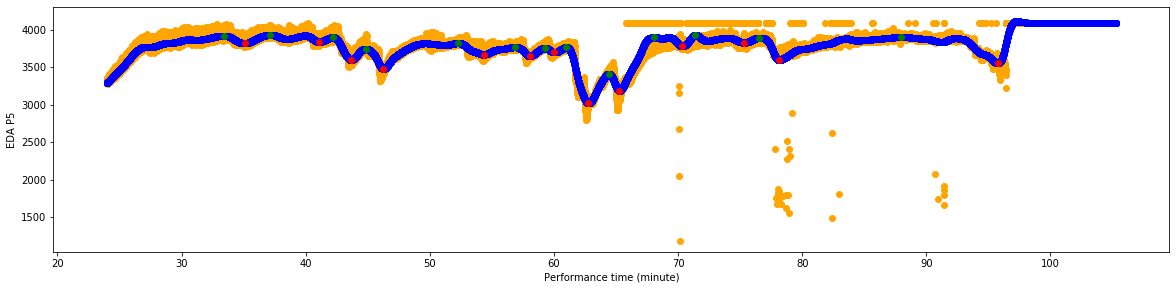

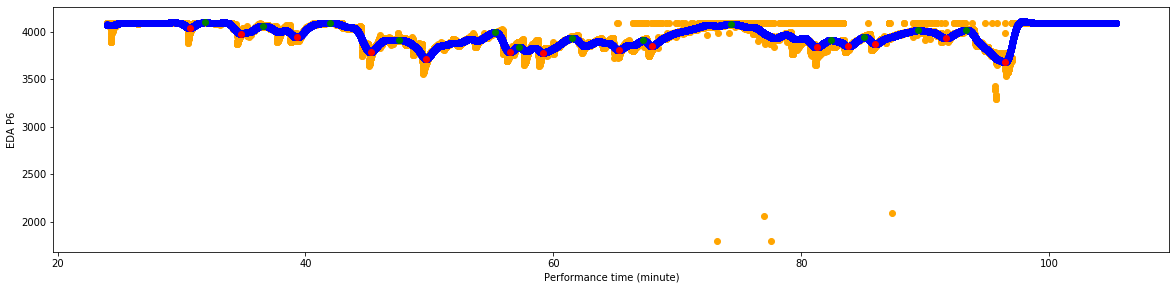

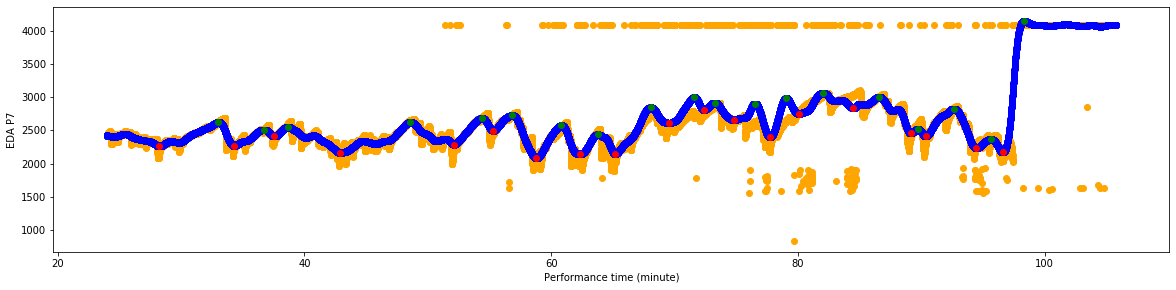

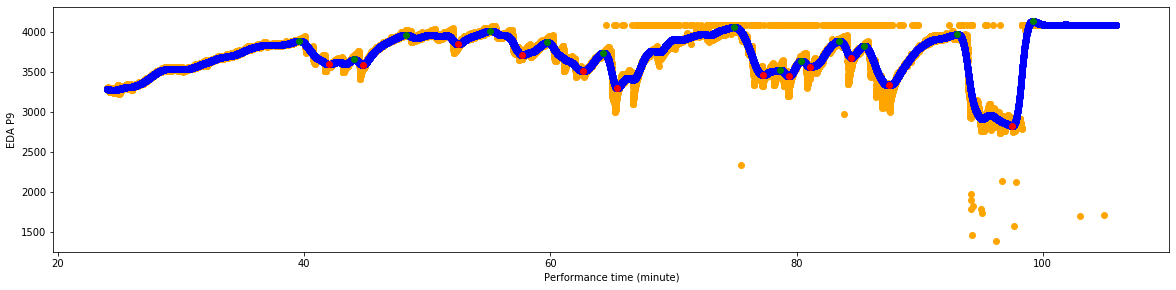

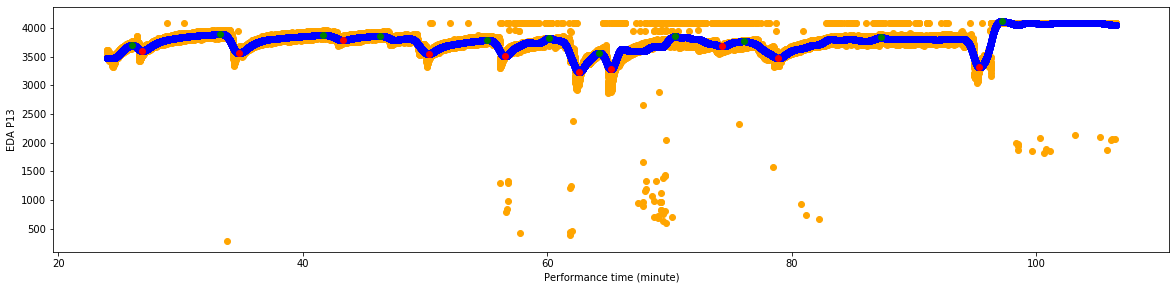

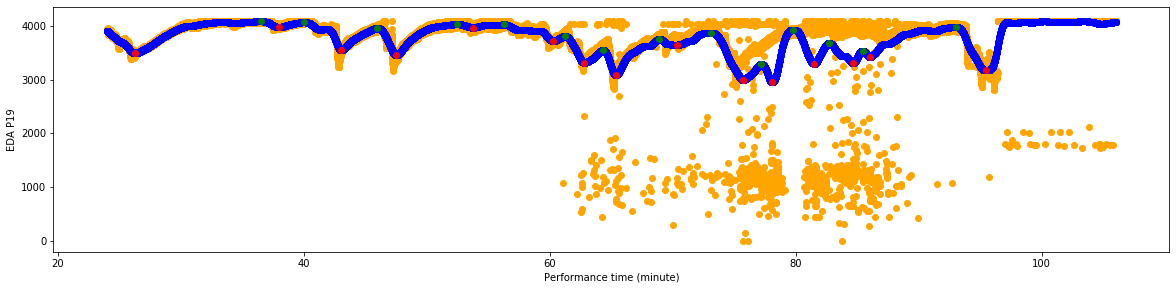

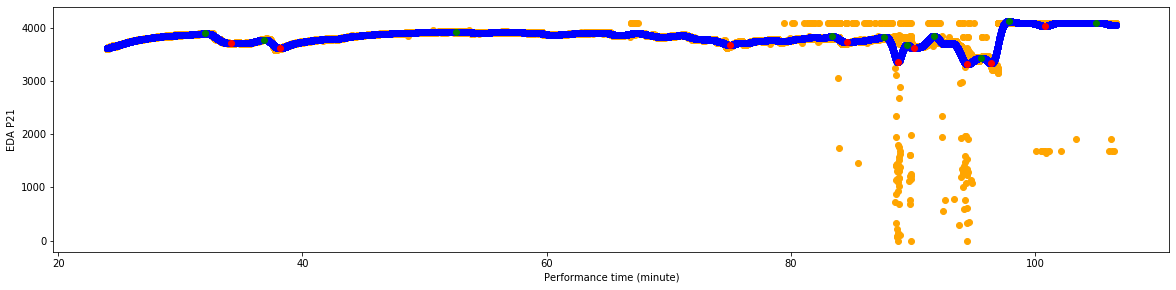

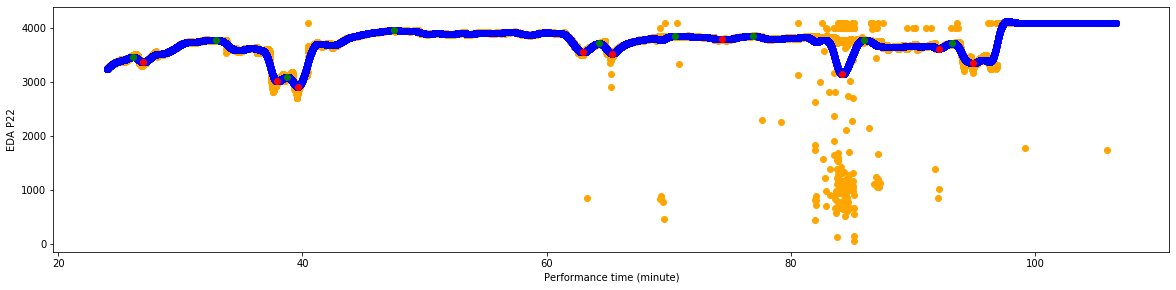

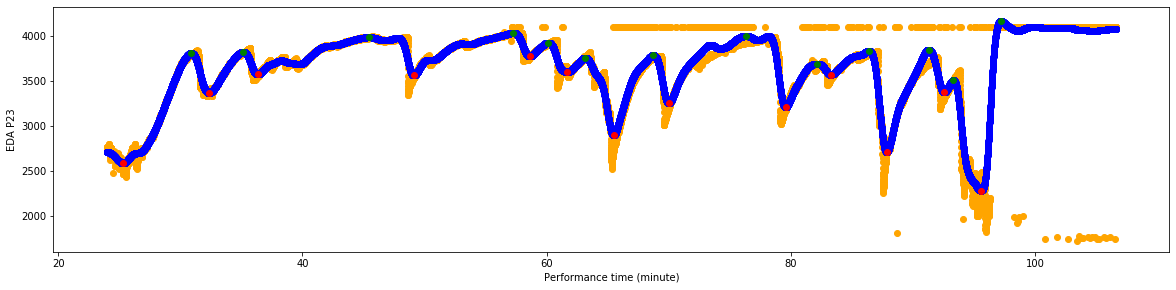

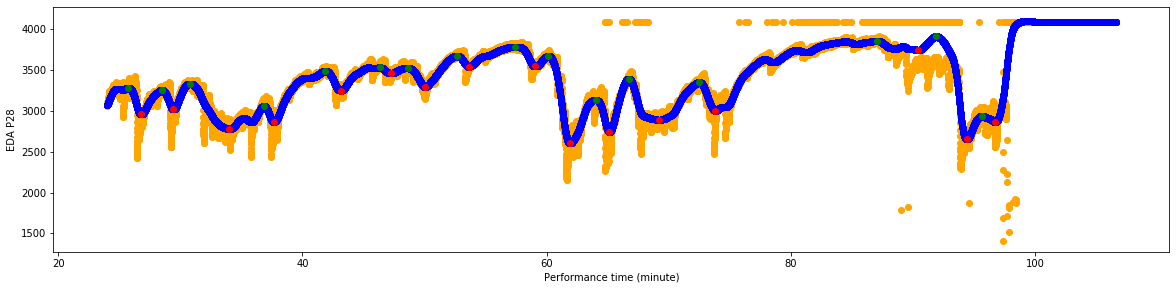

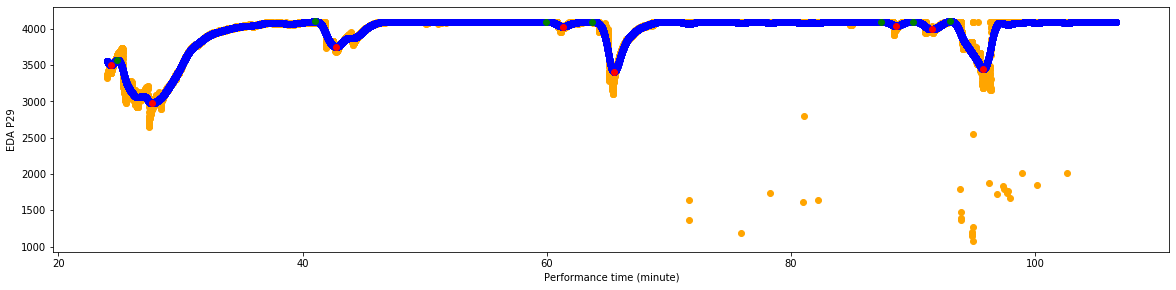

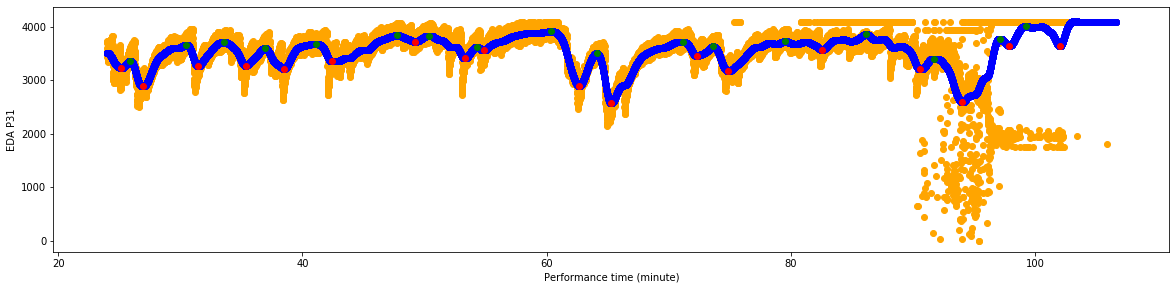

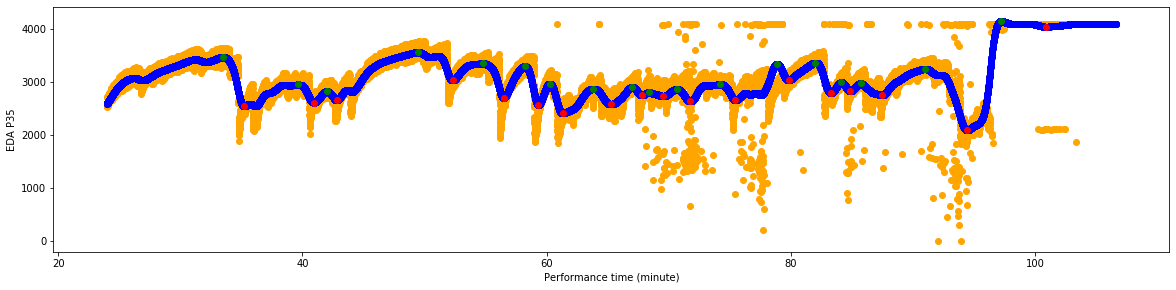

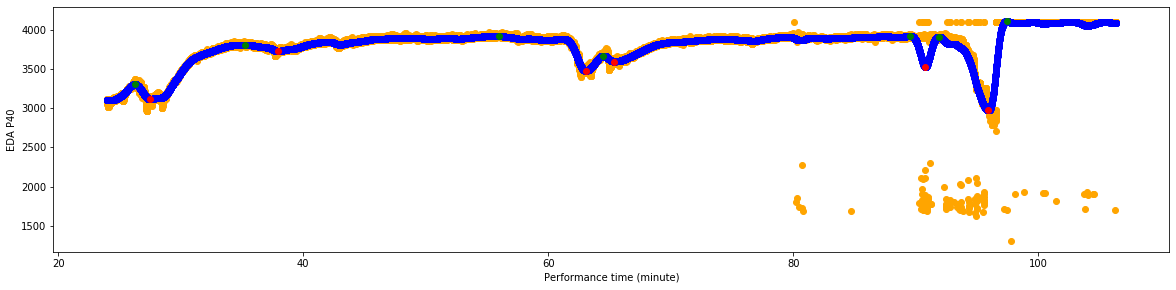

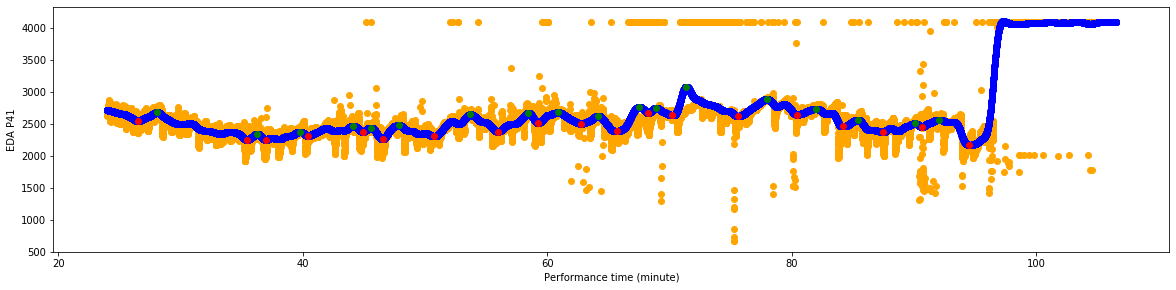

In [22]:
for i in range(1, int(participantsN[perfNumber-1])):
    df = pd.DataFrame()
    df['X'] = allData_eda[allData_eda['participantNumber'] == i]['localTimeZeroedMin']
    df['Y'] = allData_eda[allData_eda['participantNumber'] == i]['eda_filtered_good']
    df['Y2'] = allData_eda[allData_eda['participantNumber'] == i]['eda']
    df['participantNumber'] = i
    df['performanceNumber'] = perfNumber
    
    if(df['Y'].shape[0] < 10000):
        continue     
    if i in malfunctioning[perfNumber-1]:
        continue   
    for col in df:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # 4.54 Hz
    n= round(4.54*60*0.5) # number of points to be checked before and after 
    # Find local peaks
    
    df['max'] = df.iloc[ find_peaks(df['Y'], prominence=50, distance=n)[0]]['Y']
    df['min'] = df.iloc[ find_peaks(df['Y']*-1 + 4095*2, prominence=50, distance=n)[0]]['Y']
    dfminmax = dfminmax.append(df, ignore_index=True)

    # plot EDA extremas
    plt.figure(figsize=(20,4.5))
    plt.scatter(df['X'], df['Y2'], c='orange')
    plt.scatter(df['X'], df['Y'], c='b')
    plt.scatter(df['X'], df['min'], c='r')
    plt.plot(df['X'], df['max'], 'o', c='g')
    plt.ylabel('EDA P'+str(i))
    plt.xlabel('Performance time (minute)')
    plt.show()


## Aggregate EDA extrema counts

In [9]:
dfmin = pd.DataFrame()
dfmax = pd.DataFrame()
dfmin = dfmin.append(dfminmax, ignore_index = True)
dfmax = dfmax.append(dfminmax, ignore_index = True)


binSizeMinutes = 1

dfmin.dropna( subset=['min'], inplace=True)
dfmax.dropna( subset=['max'], inplace=True)
dfmin['X-bins'] = dfmin['X'] // binSizeMinutes
dfmax['X-bins'] = dfmax['X'] // binSizeMinutes


binsMin = pd.DataFrame(columns=['time','sizeMin','number','extrema'])
binsMax = pd.DataFrame(columns=['time','sizeMin','number','extrema'])

earliestbin = dfmin['X-bins'].min()
dfmin['X-binsZeroed'] = dfmin['X-bins'] - earliestbin
latestbin = dfmin['X-binsZeroed'].max()

for i in range(0, int(latestbin+1)):
    numberOfExtremaInBin = dfmin['X-binsZeroed'][(dfmin['X-binsZeroed'] == i)].count()
    #print (i, numberOfExtremaInBin)
    binsMin = binsMin.append({'time':int(earliestbin*binSizeMinutes + binSizeMinutes*i), 'sizeMin':binSizeMinutes, 'number':i, 'extrema':numberOfExtremaInBin}, ignore_index=True)

    
earliestbin = dfmax['X-bins'].min()
dfmax['X-binsZeroed'] = dfmax['X-bins'] - earliestbin
latestbin = dfmax['X-binsZeroed'].max()

for i in range(0, int(latestbin+1)):
    numberOfExtremaInBin = dfmax['X-binsZeroed'][(dfmax['X-binsZeroed'] == i)].count()
    #print (i, numberOfExtremaInBin)
    binsMax = binsMax.append({'time':earliestbin*binSizeMinutes + binSizeMinutes*i, 'sizeMin':binSizeMinutes, 'number':i, 'extrema':numberOfExtremaInBin}, ignore_index=True)

    
    
binsMin['number'] = binsMin['number'].astype(int)
binsMax['number'] = binsMax['number'].astype(int)

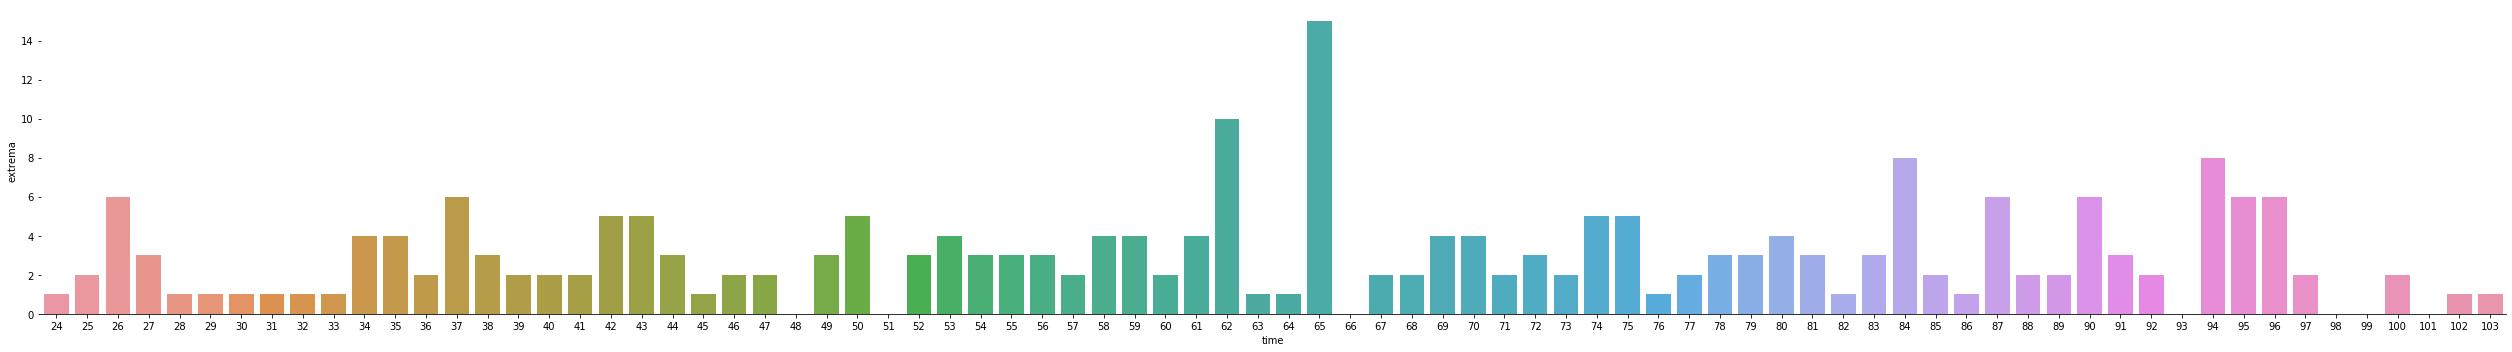

In [10]:
g = sns.catplot(x="time", y="extrema", data=binsMin,
                height=5, aspect=7, kind="bar")
g.despine(left=True)

In [11]:
# Find outstanding EDA extrema counts('bars')
binsMin['peaks'] =binsMin.iloc[ find_peaks(binsMin['extrema'],distance=2,prominence=binsMin['extrema'].std()*1.5)[0]]['extrema']